In [1]:
#Instal seaborn for graphs
pip install seaborn

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from PIL import Image
from scipy.stats import skew
from matplotlib.transforms import Bbox

In [2]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [3]:
#Upload dataset
df = pd.read_csv("/content/SAML-D 3.csv")

In [5]:
#Top five rows
df.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2.769355e+09,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0.0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8.401255e+09,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0.0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4.404767e+09,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0.0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9.600420e+09,11895.00,UK pounds,UK pounds,UK,UK,ACH,0.0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3.803337e+09,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0.0,Normal_Cash_Deposits


In [10]:
#Bottom five rows
df.tail()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
270241,17:05:27,2022-10-16,8730672459,7871228800,5043.87,UK pounds,UK pounds,UK,UK,Debit card,0.0,Normal_Fan_In
270242,17:05:29,2022-10-16,2935045772,860734312,21273.34,UK pounds,UK pounds,UK,UK,Debit card,0.0,Normal_Small_Fan_Out
270243,17:05:30,2022-10-16,8658677835,1936507262,68.10,UK pounds,UK pounds,UK,UK,Cash Withdrawal,0.0,Normal_Cash_Withdrawal
270244,17:05:31,2022-10-16,3618079400,5005494886,16195.74,UK pounds,UK pounds,UK,UK,Debit card,0.0,Normal_Fan_In
270245,17:05:32,2022-10-16,7284285120,8015453809,9878.74,UK pounds,UK pounds,UK,UK,Credi,NaN,NaN


### Exploratory Data Analysis

In [11]:
# number of transactions per payment type
transactions_per_payment_type = df['Payment_type'].value_counts()

# number of laundering transactions per payment type
laundering_transactions_per_payment_type = df[df['Is_laundering'] == 1].groupby('Payment_type').size()

transactions_per_payment_type, laundering_transactions_per_payment_type

(Payment_type
 ACH                57848
 Credit card        57541
 Debit card         57514
 Cheque             57229
 Cross-border       26106
 Cash Withdrawal     8586
 Cash Deposit        5421
 Credi                  1
 Name: count, dtype: int64,
 Payment_type
 ACH                36
 Cash Deposit       34
 Cash Withdrawal    43
 Cheque             38
 Credit card        48
 Cross-border       84
 Debit card         42
 dtype: int64)

In [12]:
#basic descriptive statistics
df.describe()

,Sender_account,Receiver_account,Amount,Is_laundering
count,2.702460e+05,2.702460e+05,2.702460e+05,270245.000000
mean,4.977769e+09,5.056217e+09,8.721945e+03,0.001203
std,2.870567e+09,2.837537e+09,2.585553e+04,0.034658
min,9.217200e+04,4.823800e+04,8.830000e+00,0.000000
25%,2.517568e+09,2.619017e+09,2.137505e+03,0.000000
50%,4.930506e+09,5.088761e+09,6.153550e+03,0.000000
75%,7.439555e+09,7.519066e+09,1.041864e+04,0.000000
max,9.999706e+09,9.999971e+09,6.213932e+06,1.000000


In [7]:
# Remove rows with missing data
df = df.dropna()

# Check for missing data
missing_data = df.isnull().sum()

missing_data

Time                      0
Date                      0
Sender_account            0
Receiver_account          0
Amount                    0
Payment_currency          0
Received_currency         0
Sender_bank_location      0
Receiver_bank_location    0
Payment_type              0
Is_laundering             0
Laundering_type           0
dtype: int64

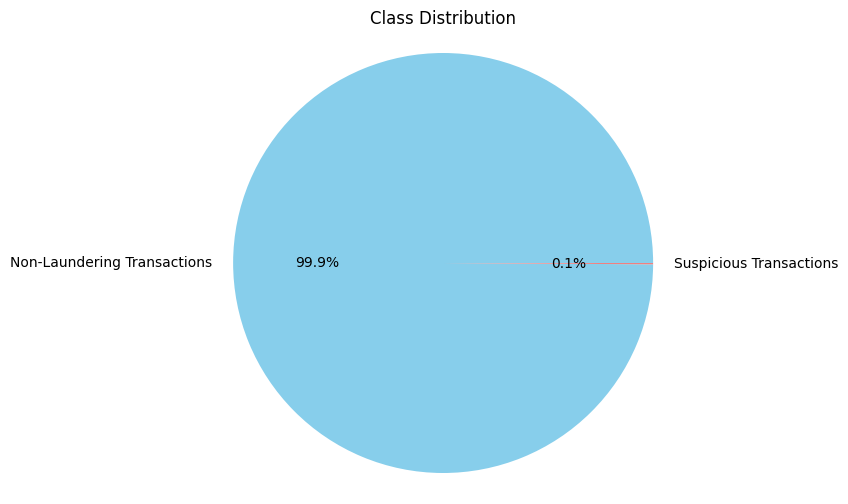

In [8]:
# Target variable pie chart
class_distribution = df['Is_laundering'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(class_distribution, labels=['Non-Laundering Transactions', 'Suspicious Transactions'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])

plt.title('Class Distribution')
plt.axis('equal')

plt.show()

##Data Preprocessing

In [9]:
#Check top five rows
df.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2.769355e+09,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0.0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8.401255e+09,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0.0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4.404767e+09,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0.0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9.600420e+09,11895.00,UK pounds,UK pounds,UK,UK,ACH,0.0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3.803337e+09,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0.0,Normal_Cash_Deposits


In [10]:
## Dropping some columns

columns_to_drop = ['Laundering_type', 'Time', 'Date']

df.drop(columns=columns_to_drop, inplace=True)

df.columns

Index(['Sender_account', 'Receiver_account', 'Amount', 'Payment_currency',
       'Received_currency', 'Sender_bank_location', 'Receiver_bank_location',
       'Payment_type', 'Is_laundering'],
      dtype='object')

In [12]:
#check data types
df.dtypes

Sender_account              int64
Receiver_account          float64
Amount                    float64
Payment_currency           object
Received_currency          object
Sender_bank_location       object
Receiver_bank_location     object
Payment_type               object
Is_laundering             float64
dtype: object

In [14]:
#Transform the data
categorical_cols = ['Sender_account', 'Receiver_account', 'Payment_currency', 'Received_currency',
                   'Sender_bank_location', 'Receiver_bank_location', 'Payment_type']

for col in categorical_cols:
    encoder = preprocessing.LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

In [15]:
#Check transformed data
df.head()

,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering
0,186507,151437,1459.15,10,10,16,16,1,0.0
1,31765,460385,6019.64,10,1,16,15,5,0.0
2,6265,241706,14328.44,10,10,16,16,3,0.0
3,114777,525948,11895.00,10,10,16,16,0,0.0
4,205502,208606,115.25,10,10,16,16,1,0.0


In [16]:
# Fix amount skewness
skewed_data = df['Amount']
original_skewness = skew(skewed_data)
print(f"Original Skewness: {original_skewness}")

log_transformed_data = np.log1p(skewed_data)
transformed_skewness = skew(log_transformed_data)
print(f"Log-Transformed Skewness: {transformed_skewness}")

df['Amount'] = log_transformed_data

Original Skewness: 79.92504022476474
Log-Transformed Skewness: -1.0058761957632396


In [17]:
df.head()

,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering
0,186507,151437,7.286294,10,10,16,16,1,0.0
1,31765,460385,8.702949,10,1,16,15,5,0.0
2,6265,241706,9.570071,10,10,16,16,3,0.0
3,114777,525948,9.383957,10,10,16,16,0,0.0
4,205502,208606,4.755743,10,10,16,16,1,0.0


In [18]:
# Check for missing data
missing_data = df.isnull().sum()

missing_data

Sender_account            0
Receiver_account          0
Amount                    0
Payment_currency          0
Received_currency         0
Sender_bank_location      0
Receiver_bank_location    0
Payment_type              0
Is_laundering             0
dtype: int64

In [19]:
#Let's define our independent variable (X) and dependant/target variable y
X = df.drop(['Is_laundering'],axis=1)
y = df['Is_laundering']
print(X.head(),"\n")
print(y.head())

   Sender_account  Receiver_account    Amount  Payment_currency  \
0          186507            151437  7.286294                10   
1           31765            460385  8.702949                10   
2            6265            241706  9.570071                10   
3          114777            525948  9.383957                10   
4          205502            208606  4.755743                10   

   Received_currency  Sender_bank_location  Receiver_bank_location  \
0                 10                    16                      16   
1                  1                    16                      15   
2                 10                    16                      16   
3                 10                    16                      16   
4                 10                    16                      16   

   Payment_type  
0             1  
1             5  
2             3  
3             0  
4             1   

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Is_laundering, 

In [20]:
# Install the imbalanced-learn package
!pip install imbalanced-learn

# Import the SMOTE class
from imblearn.over_sampling import SMOTE

In [21]:
#Using SMOTE(Synthetic Minority Oversampling Technique) for balancing the dataset.
#Resulted counts show that now we have exact number of class instances (1 and 0).

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)


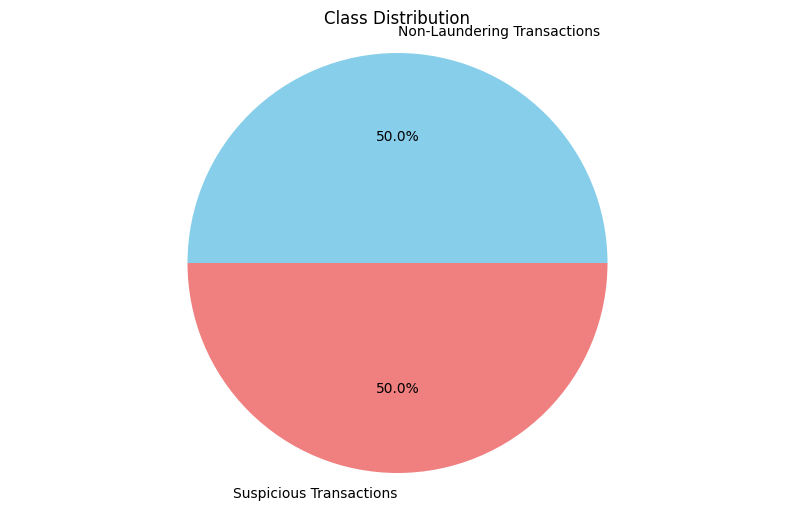

In [22]:
#Check target variable is balanced

class_distribution = y_res['Is_laundering'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(class_distribution, labels=['Non-Laundering Transactions', 'Suspicious Transactions'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])

plt.title('Class Distribution')
plt.axis('equal')

plt.show()


In [23]:
#import library
from sklearn.model_selection import train_test_split
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

In [24]:
#import libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Create a differentially private Naive Bayes classifier
clf = GaussianNB()
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.600697183075416


In [25]:
#install differential privacy package
!pip install diffprivlib

In [34]:
from sklearn.linear_model import LogisticRegression
from diffprivlib.models import LogisticRegression as DPLR
from sklearn.metrics import accuracy_score

# Flatten y_train to make it one-dimensional
y_train = np.ravel(y_train)

# Train a regular logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy of regular logistic regression:", accuracy_lr)

# Specify the L2 norm of the data
data_norm = np.sqrt(X_train.shape[1])

# Train a differentially private logistic regression model
dp_lr = DPLR(epsilon=1.0, data_norm=data_norm)
dp_lr.fit(X_train, y_train)
y_pred_dp_lr = dp_lr.predict(X_test)
accuracy_dp_lr = accuracy_score(y_test, y_pred_dp_lr)
print("Accuracy of differentially private logistic regression:", accuracy_dp_lr)

Accuracy of regular logistic regression: 0.5150612057740427
Accuracy of differentially private logistic regression: 0.5
